## Preparation

In [1]:
# Library imports
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import seaborn as sns
import networkx as nx
import numpy as np
import os
# http://stat-computing.org/dataexpo/2009/the-data.html

About the following imports:
* _airports_ contains coordinates for airports in the USA.
* _carriers_ contains airport names and cities that are useful for data merging and indexing.
* _codes_ contains airport codes useful for merging and indexing (Source:http://www.airportcodes.us/us-airports.htm)

In [2]:
# Data imports (files attached in the email assignment)
carriers  = pd.read_excel('Data/carriers.xls')
carriers.columns = ['UniqueCarrier','Description']
carriers.dropna(how="all", inplace=True) 
codes = pd.read_csv('Data/airport_codes.csv') 
codes = codes.set_index('Code').to_dict()
airports  = pd.read_excel('Data/airports new.xlt')
airports = airports.query("country=='USA'")
airports.head()

,iata,airport,city,state,country,lat,long
0,00M,Thigpen,Bay Springs,MS,USA,31.953765,-89.234505
1,00R,Livingston Municipal,Livingston,TX,USA,30.685861,-95.017928
2,00V,Meadow Lake,Colorado Springs,CO,USA,38.945749,-104.569893
3,01G,Perry-Warsaw,Perry,NY,USA,42.741347,-78.052081
4,01J,Hilliard Airpark,Hilliard,FL,USA,30.688012,-81.905944


## Basic exploration

Just out of curiosity, I plotted the number of airports in each State. There are big states with not that many airports, and smaller states with a large amount of airports.

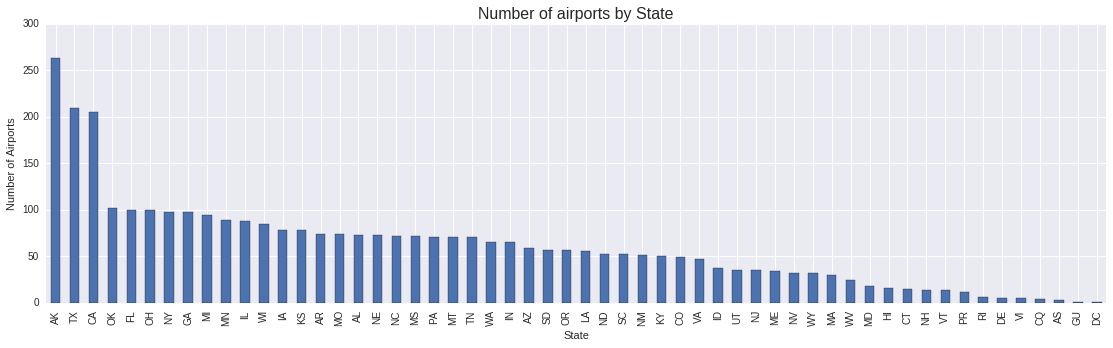

In [3]:
plt.figure(figsize=(19,5))
airports.state.value_counts().plot(kind='bar')
plt.title('Number of airports by State',fontsize=16)
plt.xlabel('State')
plt.ylabel('Number of Airports')

Again, out of curiosity, I plotted the distribution of our airports in question. It follows the known patterns in US American geography and political divisions.

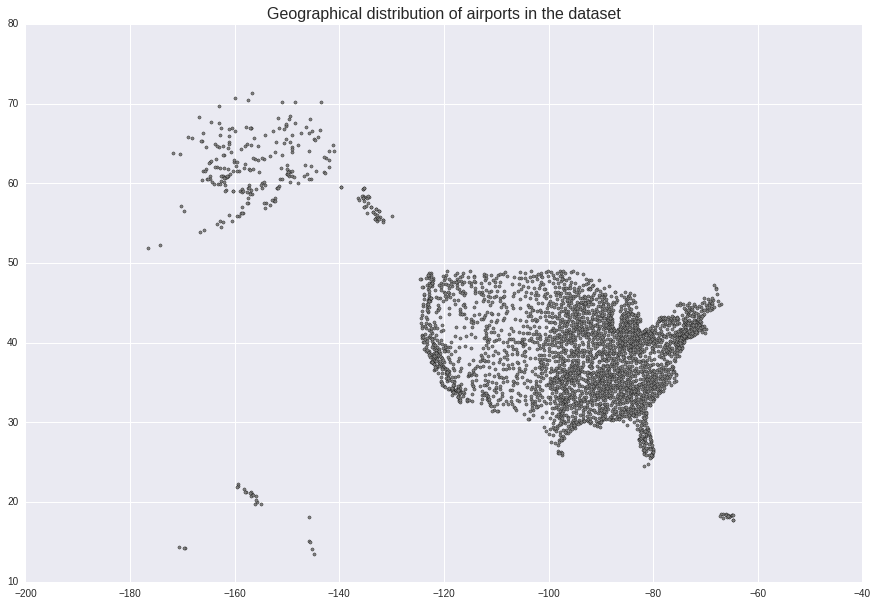

In [4]:
plt.figure(figsize=(15,10))
plt.scatter(airports.long,airports.lat,s=10,c='grey')
plt.title('Geographical distribution of airports in the dataset',fontsize=16)
plt.show()

For the centrality index I will only be working with 2008 data.

In [5]:
trips_08 = pd.read_csv('Data/trips/2008.csv',usecols=['Origin','Dest','UniqueCarrier','Year','ActualElapsedTime','CRSElapsedTime','ArrDelay','DepDelay','Distance','Cancelled'])
trips_08.head()

,Year,UniqueCarrier,ActualElapsedTime,CRSElapsedTime,ArrDelay,DepDelay,Origin,Dest,Distance,Cancelled
0,2008,WN,128.0,150.0,-14.0,8.0,IAD,TPA,810,0
1,2008,WN,128.0,145.0,2.0,19.0,IAD,TPA,810,0
2,2008,WN,96.0,90.0,14.0,8.0,IND,BWI,515,0
3,2008,WN,88.0,90.0,-6.0,-4.0,IND,BWI,515,0
4,2008,WN,90.0,90.0,34.0,34.0,IND,BWI,515,0


In [6]:
print("The total number of flights was " + str(len(trips_08)) + " whereas the number of not cancelled trips was " +str(trips_08.Cancelled.value_counts()[0]) + ". The percentage of cancellation is " + str(100 - 100*trips_08.Cancelled.value_counts()[0] / len(trips_08)) + " %" )

The total number of flights was 7009728 whereas the number of not cancelled trips was 6872294. The percentage of cancellation is 1.96061815808 %


In the following lines I create a single data set with carriers, locations and trips:

In [7]:
airports = airports[['airport','city','lat','long']].set_index('city').to_dict() # Useful for mapping airports to coordinates

data = trips_08.merge(carriers,on='UniqueCarrier')
data["origin_city"] = data["Origin"].map(codes['City'])
data["destin_city"] = data["Dest"].map(codes['City'])
data["origin_lat"]  = data["origin_city"].map(airports['lat'])
data["origin_long"] = data["origin_city"].map(airports['long'])
data["destin_lat"]  = data["destin_city"].map(airports['lat'])
data["destin_long"] = data["destin_city"].map(airports['long'])

The following data set comprises the average arrival, departure and total delay between every existing origin-destination pair in 2008:

In [8]:
# Average delays between airports
delays = data.groupby(['origin_city','destin_city'])[['ArrDelay','DepDelay']].mean().reset_index()
delays['Total_delay'] = delays.ArrDelay+delays.DepDelay
delays.head()

,origin_city,destin_city,ArrDelay,DepDelay,Total_delay
0,Abilene,Dallas,5.037490,6.880397,11.917888
1,Adak Island,Anchorage,4.532609,13.652174,18.184783
2,Aguadilla,New York,-0.175038,0.811263,0.636225
3,Aguadilla,Newark,6.271978,11.863014,18.134992
4,Aguadilla,Orlando,2.563786,6.557377,9.121163


In [9]:
print('Airport with lenghtiest delays at departure: ' + delays.groupby('origin_city')['DepDelay'].mean().idxmax())
print('Airport with lenghtiest delays at arrival: ' + delays.groupby('destin_city')['ArrDelay'].mean().idxmax())
print('Airport with lenghtiest total delays: ' + delays.groupby('destin_city')['Total_delay'].mean().idxmax())

More notes on exploration: this is a simple (and naive) plot comparing distance between airports and total delays.

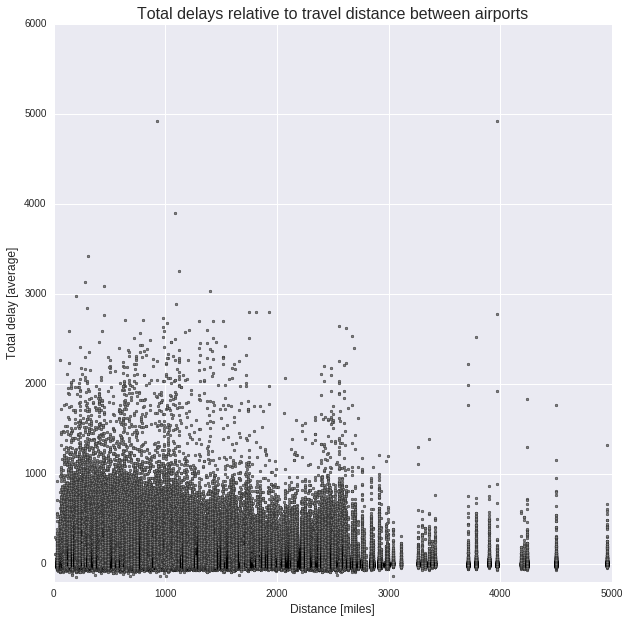

In [10]:
plt.figure(figsize=(10,10))
plt.scatter(data.Distance,data.ArrDelay+data.DepDelay,c='grey',s=8)
plt.xlim([0,5000])
plt.ylim([-200,6000])
plt.title('Total delays relative to travel distance between airports',fontsize=16)
plt.xlabel('Distance [miles]',fontsize=12)
plt.ylabel('Total delay [average]',fontsize=12)

The following table summarizes the number of trips between airports in that year.

In [11]:
trips = data.groupby(['origin_city','destin_city'])[['UniqueCarrier']].count().reset_index()
trips.columns = ['origin_city','destin_city','Count']
trips.head()

,origin_city,destin_city,Count
0,Abilene,Dallas,2660
1,Adak Island,Anchorage,102
2,Aguadilla,New York,661
3,Aguadilla,Newark,366
4,Aguadilla,Orlando,492


Let us represent this data set as a network, where edges are trips between airports, weights are the number of trips and the nodes are airports.

In [12]:
# Some data cleaning and preparation
data = data[data['origin_lat'].notnull()] 
data = data[data['origin_long'].notnull()]
data['coord'] = zip(data['origin_long'],data['origin_lat'])

In [13]:
# Location of the nodes
pos  = data[['origin_city','coord']].dropna().set_index('origin_city').to_dict()
# Network representation
G=nx.Graph()
G.add_nodes_from(list(pd.unique(trips.origin_city.dropna())))
G.add_weighted_edges_from(zip(trips['origin_city'].dropna(),trips['destin_city'].dropna(),trips['Count'].dropna()))

The following is a (not very appealing) graph of all the trips between airports.

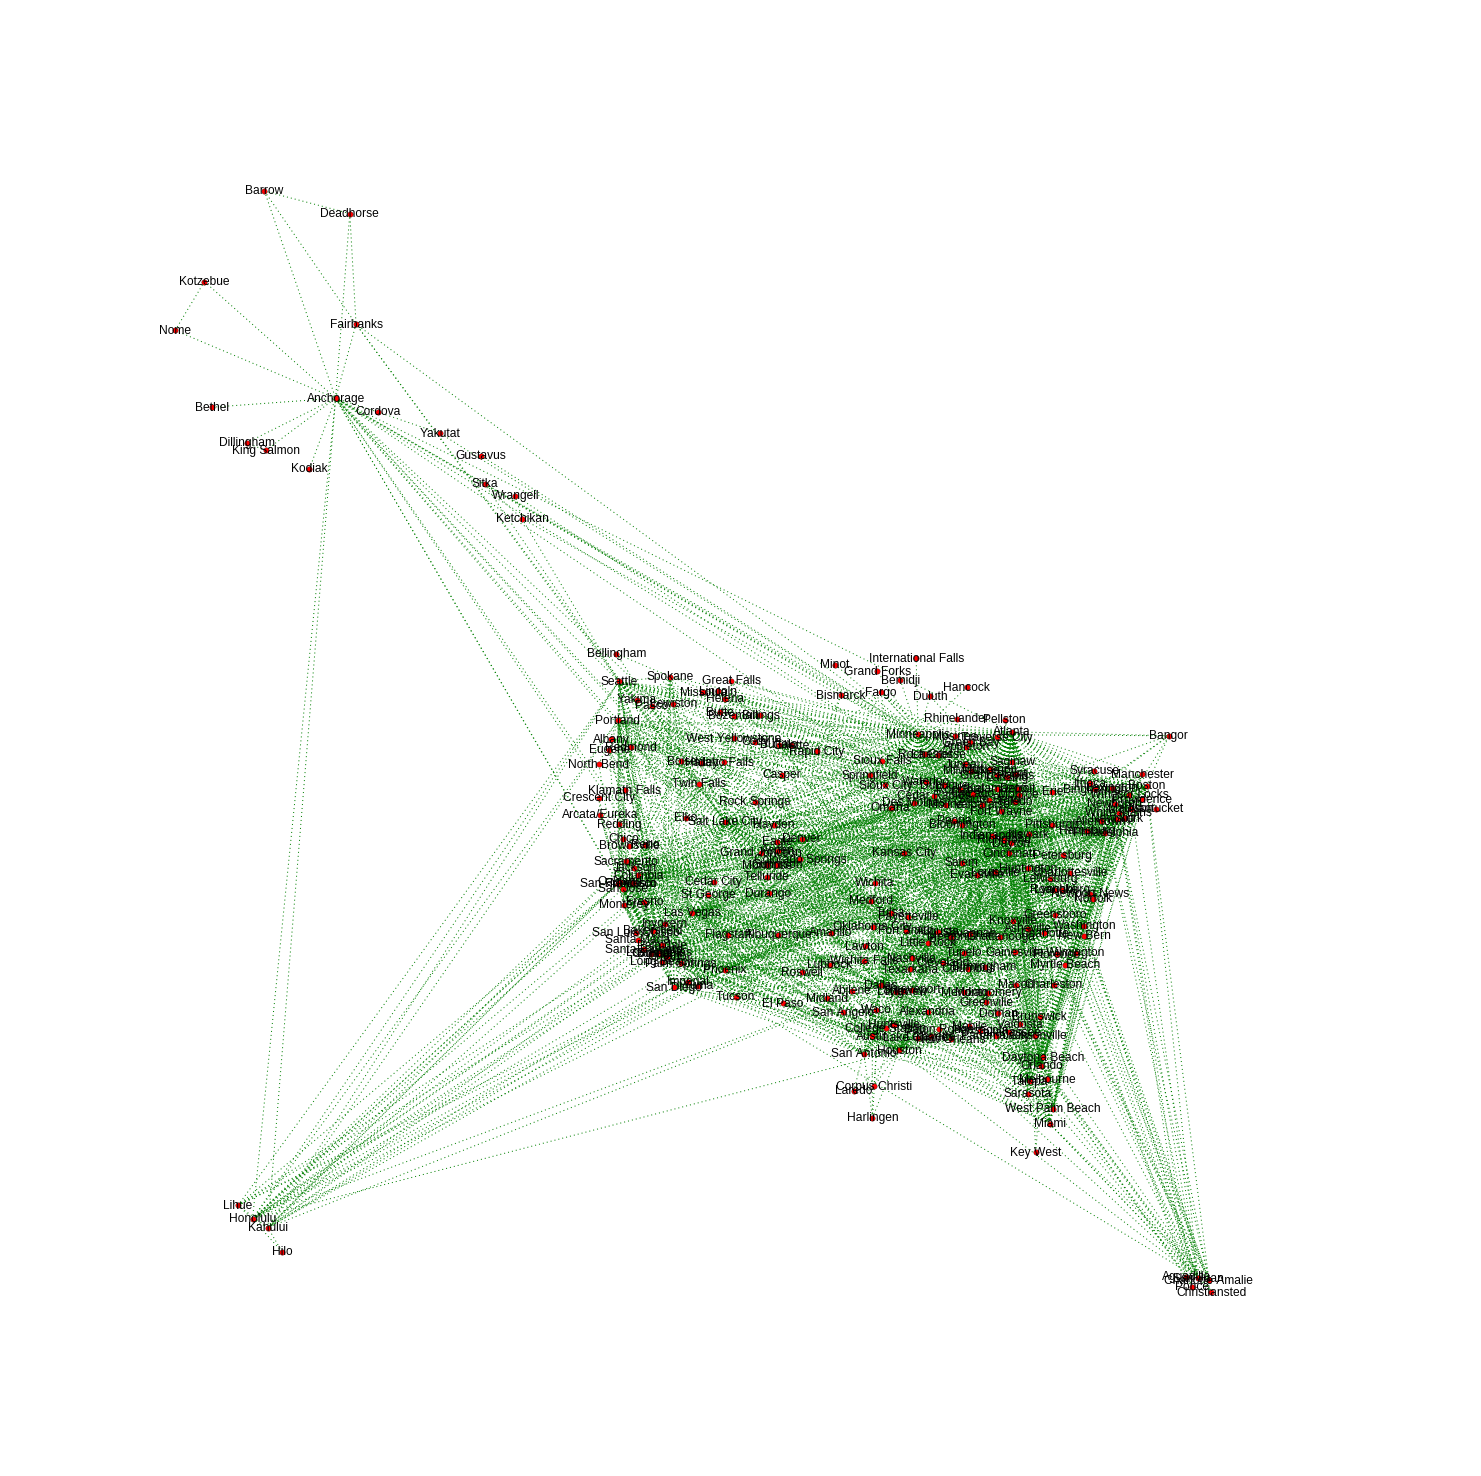

In [14]:
## G.remove_nodes_from(['Keahole','Orange County','Gulfport','North Canton','Elmira / Corning','Champaign','Fort Lauderdale','Rdu Airport','Avoca','Saint Petersburg','Saint Louis','Blountville','BWI Airport','Fort Myers','Mcallen','Pocatello','South Burlington'])
G.remove_nodes_from(['Fort Hood / Killeen','Pierre','Pueblo','Ogden','Keahole','Fayetteville / Springdale','Adak Island','Egg Harbor Township','Cheyenne','Beaumont / Port Arthur','Champaign','Orange County','BWI Airport','Gulfport','South Burlington','North Canton','Elmira / Corning','Fort Lauderdale','Rdu Airport','Avoca','Saint Petersburg','Saint Louis','Blountville','Fort Myers','Mcallen','Pocatello'])
plt.figure(figsize=(20,20))
nx.draw(G,pos=pos['coord'],with_labels=True,node_size=30,style='dotted',edge_color='green')

In [15]:
d=G.degree().values()
j=np.argmax(d)
print('The most connected airport is {0} with {1} connections'.format(G.degree().keys()[j],d[j]))

The most connected airport is Atlanta with 144 connections


Let us represent the airports in terms of their betweeness centrality relative to their average arrival and departure delays.

In [16]:
delays = delays[delays.destin_city != "Pierre"]
ar_delays  = delays.groupby(['destin_city'])['ArrDelay'].mean().reset_index()
dep_delays = delays.groupby(['origin_city'])['DepDelay'].mean().reset_index()

# one could argue it is the other way around
sizes_ar = nx.betweenness_centrality(G)
factor=1.0/sum(sizes_ar.itervalues())
for k in sizes_ar:
    sizes_ar[k] = sizes_ar[k]*factor
sizes_dep = sizes_ar

Top airports in terms of their betweenness centrality for domestic flights (similar for arrivals and departures):

In [17]:
temp = pd.DataFrame([]).from_dict(sizes_ar,orient='index')
temp.columns = ['Centrality']
temp.sort('Centrality',ascending=False).head(10)

/home/saf537/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,Centrality
Atlanta,0.133890
Dallas,0.085455
Salt Lake City,0.084728
Minneapolis,0.082088
Anchorage,0.058786
Chicago,0.056784
Denver,0.051072
Detroit,0.042831
Houston,0.040318
San Francisco,0.038127


Worst performing airports in terms of arrival delays:

In [18]:
ar_delays.sort('ArrDelay',ascending=False).head(10)

/home/saf537/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,destin_city,ArrDelay
254,Springfield,63.447158
12,Aspen,29.995056
106,Gunnison,28.909466
183,Nantucket,26.079958
68,Des Moines,24.121120
193,North Bend,20.736623
192,Norfolk,20.653845
51,Chico,19.905077
75,Eagle,19.462659
39,Butte,18.991971


Worst performing airports in terms of average departure delays:

In [19]:
dep_delays.sort('DepDelay',ascending=False).head(10)

/home/saf537/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,origin_city,DepDelay
43,Champaign,149.266698
225,Roanoke,51.956570
10,Arcata/Eureka,48.000720
135,Klamath Falls,47.066221
276,Wichita,39.904703
9,Appleton,36.742313
47,Charlottesville,32.597403
98,Grand Junction,31.171125
83,Fargo,30.783061
182,Nantucket,29.892045


Here we calculate a ratio: the worst performing airports relative to their performance in terms of the network (which help us find how "weak" those links are):

In [20]:
for names in sizes_ar.keys():
    sizes_ar[names] = float(ar_delays[ar_delays.destin_city==names]['ArrDelay'] / sizes_ar[names])
    
for names in sizes_dep.keys():
    #if names !='Pierre':
    sizes_dep[names] = float(dep_delays[dep_delays.origin_city==names]['DepDelay'] / sizes_dep[names])

In [21]:
# Save in separate csvs for prettier plotting
ar_df = pd.DataFrame([]).from_dict(sizes_ar,orient='index').reset_index()
ar_df.columns = ['destin_city','ind']
dep_df = pd.DataFrame([]).from_dict(sizes_dep,orient='index').reset_index()
dep_df.columns = ['origin_city','ind']
ar_df["destin_lat"]   = ar_df["destin_city"].map(airports['lat'])
ar_df["destin_long"]  = ar_df["destin_city"].map(airports['long'])
dep_df["origin_lat"]  = dep_df["origin_city"].map(airports['lat'])
dep_df["origin_long"] = dep_df["origin_city"].map(airports['long'])
dep_df.to_csv('Departure_vulnerability.csv')
ar_df.to_csv('Arrival_vulnerability.csv')

In [22]:
ar_df.sort('ind',ascending=False).head(10)

/home/saf537/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,destin_city,ind,destin_lat,destin_long
28,Atlanta,0.160344,45.000008,-84.133337
161,Salt Lake City,0.128662,40.619540,-111.992886
56,Minneapolis,0.127824,44.880547,-93.216922
133,Dallas,0.126783,32.680861,-96.868194
167,Detroit,0.101268,42.237927,-83.530409
74,Denver,0.076429,39.785250,-104.543139
165,Chicago,0.062064,41.979595,-87.904464
242,Houston,0.059642,29.508361,-95.051333
229,Anchorage,0.057610,61.214379,-149.846161
212,Phoenix,0.055963,33.434167,-112.008056


In [23]:
dep_df.sort('ind',ascending=False).head(10)

/home/saf537/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,origin_city,ind,origin_lat,origin_long
28,Atlanta,0.160344,45.000008,-84.133337
161,Salt Lake City,0.128662,40.619540,-111.992886
56,Minneapolis,0.127824,44.880547,-93.216922
133,Dallas,0.126783,32.680861,-96.868194
167,Detroit,0.101268,42.237927,-83.530409
74,Denver,0.076429,39.785250,-104.543139
165,Chicago,0.062064,41.979595,-87.904464
242,Houston,0.059642,29.508361,-95.051333
229,Anchorage,0.057610,61.214379,-149.846161
212,Phoenix,0.055963,33.434167,-112.008056


And, plotting the "vulnerability index"...

In [24]:
plt.figure(figsize=(30,30))
plt.title('Departure vulnerability index',fontsize=35)
nx.draw(G,pos=pos['coord'],with_labels=True,
        node_size=10000E1*np.array(sizes_dep.values()),style='dotted',edge_color='green')

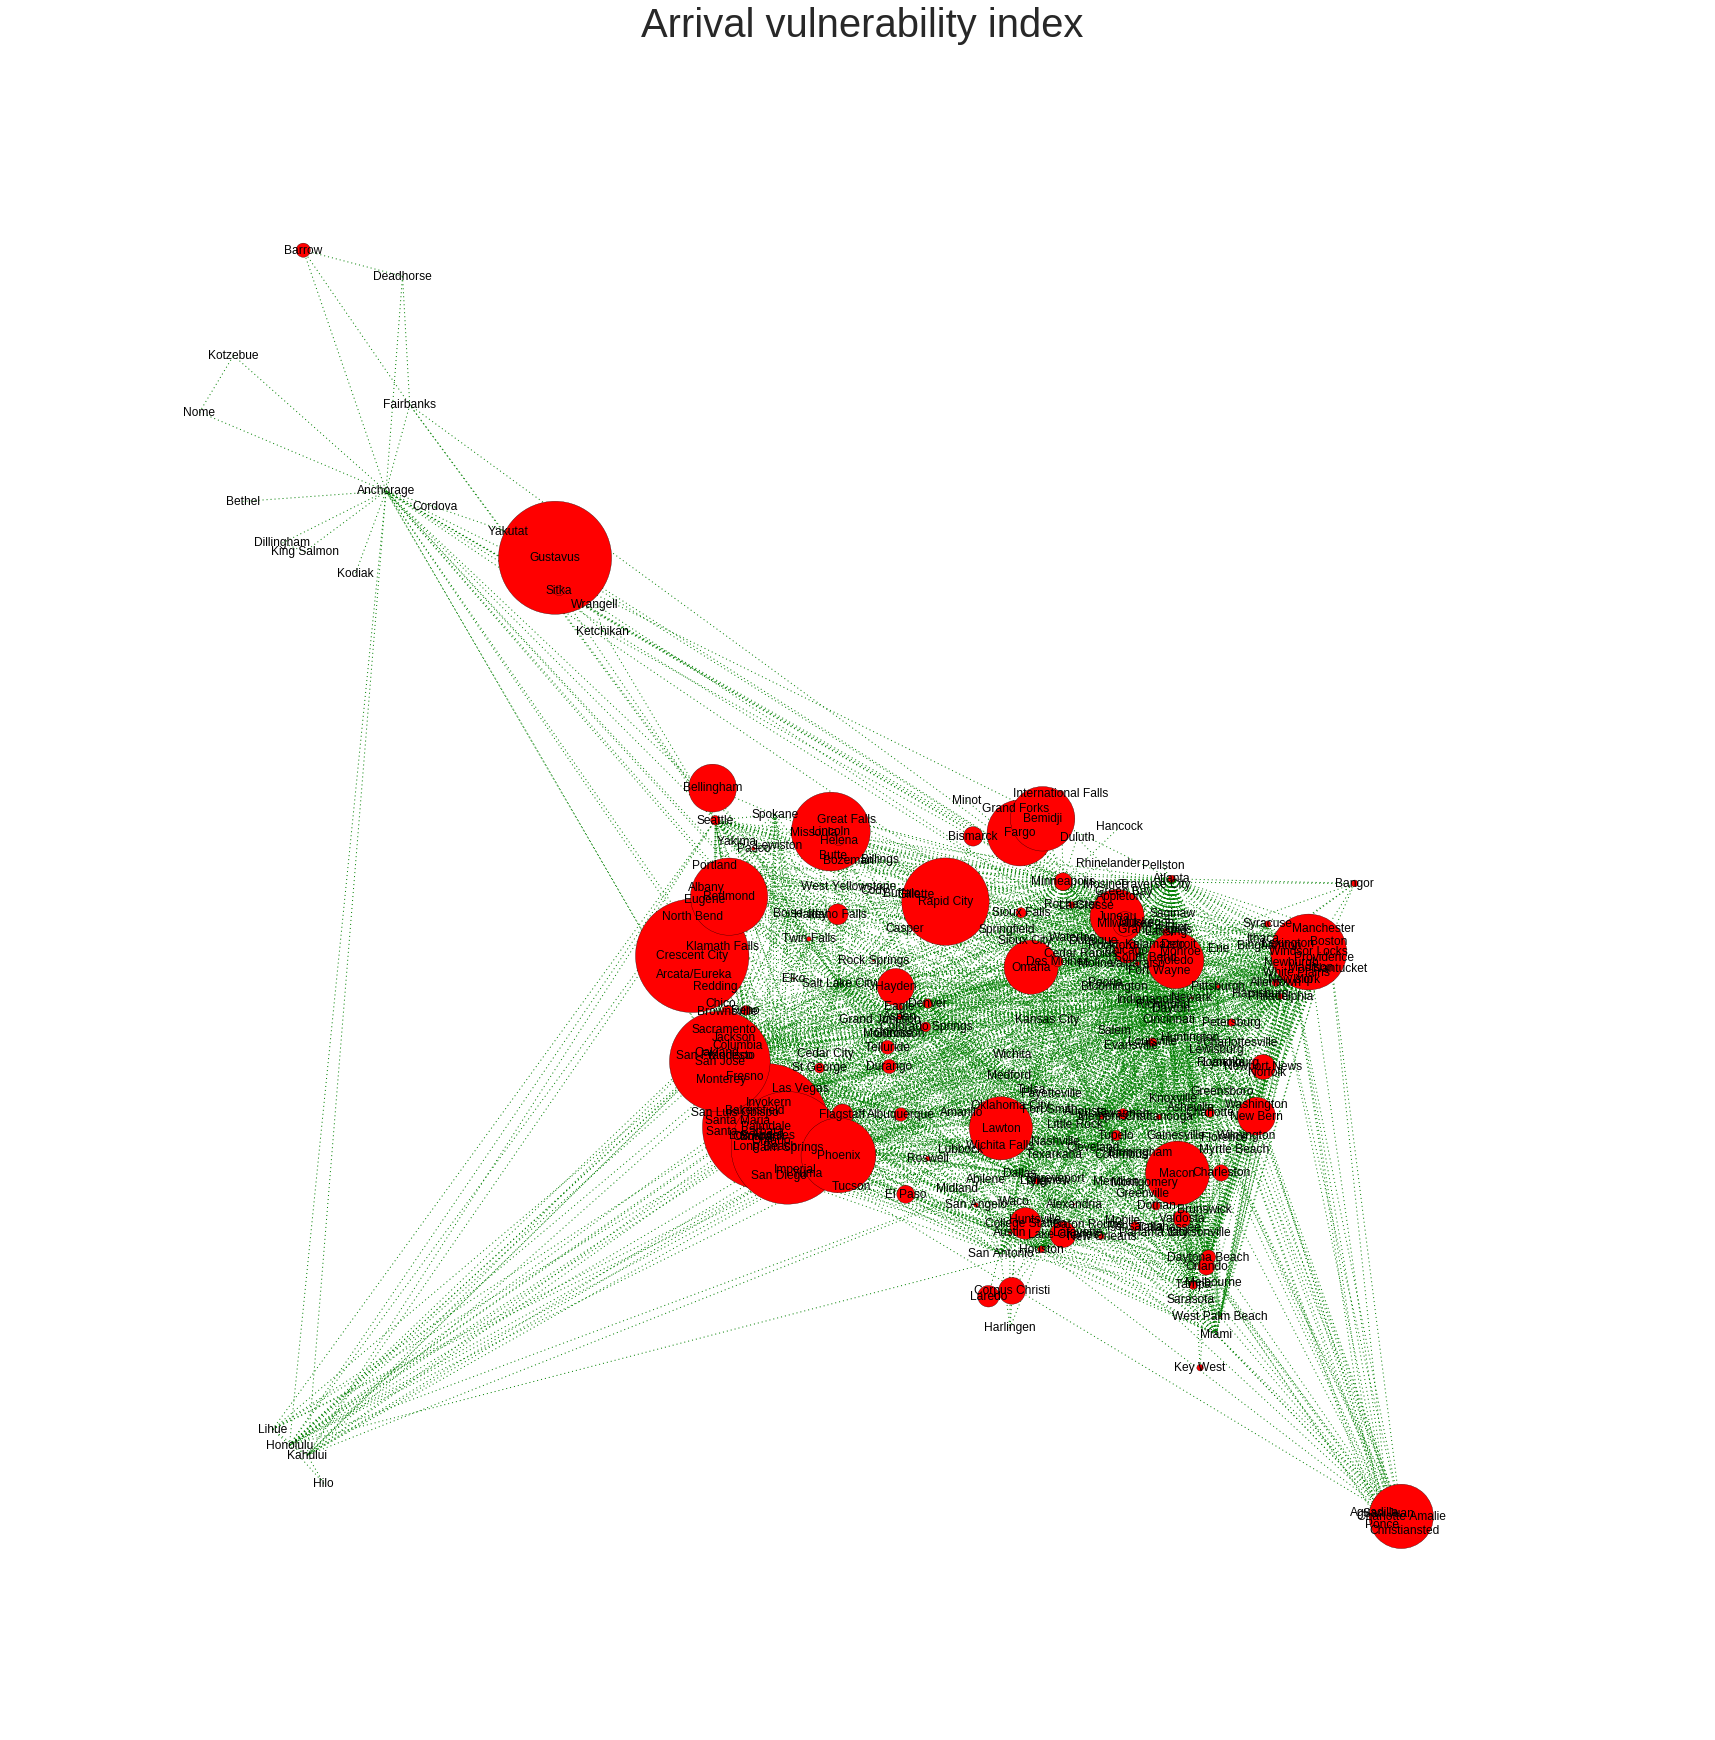

In [25]:
plt.figure(figsize=(30,30))
plt.title('Arrival vulnerability index',fontsize=40)
nx.draw(G,pos=pos['coord'],with_labels=True,
        node_size=10000E1*np.array(sizes_ar.values()),style='dotted',edge_color='green')

In [26]:
data = data[[ u'ActualElapsedTime','UniqueCarrier' ,u'CRSElapsedTime', u'origin_city', u'destin_city',u'origin_lat', u'origin_long', u'destin_lat', u'destin_long', u'coord']]
data.head()

,ActualElapsedTime,UniqueCarrier,CRSElapsedTime,origin_city,destin_city,origin_lat,origin_long,destin_lat,destin_long,coord
0,128.0,WN,150.0,Washington,Tampa,35.570468,-77.049813,28.013984,-82.345279,"(-77.04981306, 35.57046806)"
1,128.0,WN,145.0,Washington,Tampa,35.570468,-77.049813,28.013984,-82.345279,"(-77.04981306, 35.57046806)"
2,96.0,WN,90.0,Indianapolis,BWI Airport,39.935203,-86.044953,NaN,NaN,"(-86.04495333, 39.9352025)"
3,88.0,WN,90.0,Indianapolis,BWI Airport,39.935203,-86.044953,NaN,NaN,"(-86.04495333, 39.9352025)"
4,90.0,WN,90.0,Indianapolis,BWI Airport,39.935203,-86.044953,NaN,NaN,"(-86.04495333, 39.9352025)"


## Performance vs. schedule

Is performance improving? If so, is it because the airlines are scheduling for longer trips?

In [27]:
# Loading yearly RITA data (1987-2008)
lst = []
path = 'Data/trips/'
test = pd.DataFrame([])
for name in os.listdir(path):
    df = pd.read_csv(path+name,usecols=[u'ActualElapsedTime',u'CRSElapsedTime', u'Origin', u'Dest','Year','ArrDelay','DepDelay'])
    df['CRSElapsedTime'+str(df.Year[0])] =  df['CRSElapsedTime']
    df['TotDelay'+str(df.Year[0])] =  df['ArrDelay'] + df['DepDelay']
    df = df.groupby(['Origin','Dest'])[['CRSElapsedTime'+str(df.Year[0]),'TotDelay'+str(df.Year[0])]].mean()
    lst.append(df)
    del(df)

Schedule. P-value1.07790484129e-08. R2: 0.945262560245


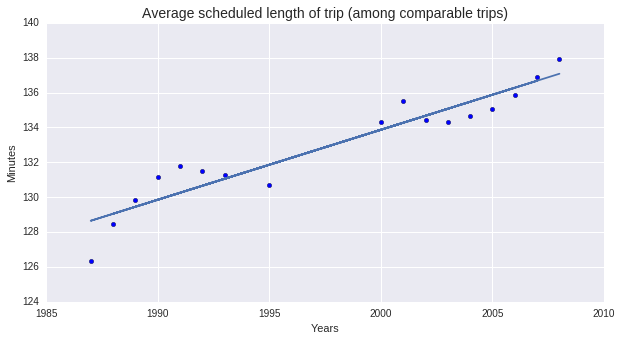

Delays. P-value0.413800225734. R2: 0.21209085352


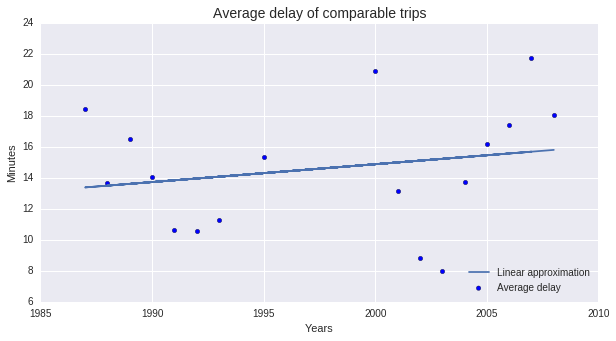

In [28]:
df    = pd.concat(lst, axis=1, join_axes=[lst[0].index]).dropna()
sched_cols = [col for col in list(df) if col.startswith('CRS')]
delay_cols = [col for col in list(df) if col.startswith('TotDelay')]
years = np.array([int(i[-4:]) for i in sched_cols])
average_length = np.array(df[sched_cols].mean())
average_delay = np.array(df[delay_cols].mean())
slope, intercept, r_value, p_value, std_err = stats.linregress(years,average_length)
print("Schedule. P-value"+str(p_value)+'. R2: '+str(r_value))
plt.figure(figsize=(10,5))
plt.title('Average scheduled length of trip (among comparable trips)',fontsize=14)
plt.xlabel('Years')
plt.ylabel('Minutes')
plt.scatter(years,average_length)
plt.plot(years,years*slope+intercept)
plt.savefig('plots/sch_trips')
plt.show()

slope, intercept, r_value, p_value, std_err = stats.linregress(years,average_delay)
print("Delays. P-value"+str(p_value)+'. R2: '+str(r_value))
plt.figure(figsize=(10,5))
plt.title('Average delay of comparable trips',fontsize=14)
plt.xlabel('Years')
plt.ylabel('Minutes')
plt.scatter(years,average_delay,label='Average delay')
plt.plot(years,years*slope+intercept,label = 'Linear approximation')   
plt.legend(loc=4)
plt.savefig('plots/del_trips')
plt.show()